In [1]:
!pip install -q pyvi scikit-learn transformers torch accelerate seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 80.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━

In [2]:
import json
import os
import gc
import pandas as pd
import numpy as np
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_recall_fscore_support
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from pyvi import ViTokenizer
import joblib
from torch.optim import AdamW

2025-12-20 14:13:36.416597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766240016.599433      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766240016.651055      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
# Cấu hình hạt giống ngẫu nhiên để kết quả ổn định
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Đang chạy trên thiết bị: {device}")

Đang chạy trên thiết bị: cuda


In [4]:
# ======================================================
# 1. ĐỊNH NGHĨA SCHEMA & RULE LỌC DỮ LIỆU
# ======================================================

# Các nhãn cần bỏ qua (lỗi hoặc không dùng)
IGNORED_LABELS = {'PER_VICTIMPACT', 'CAUSES', 'CONSEQUENCES'}

# Schema hợp lệ: {RELATION: [(SUBJECT_TYPE, OBJECT_TYPE), ...]}
VALID_SCHEMA = {
    'LOCATED_AT': [('EVENT', 'LOC')],
    'HAPPENED_ON': [('EVENT', 'TIME')],
    'INVOLVED': [
        ('EVENT', 'VEH'), 
        ('PER_DRIVER', 'VEH'), 
        ('PER_VICTIM', 'VEH')
    ],
    'CAUSED_BY': [('EVENT', 'CAUSE')],
    'HAS_CONSEQUENCE': [('EVENT', 'CONSEQUENCE')]
}

def is_valid_relation(label, s_type, o_type):
    """Kiểm tra quan hệ có đúng logic Schema không"""
    # 1. Nếu nhãn nằm trong danh sách bỏ qua -> Sai
    if label in IGNORED_LABELS:
        return False
    
    # 2. Nếu nhãn không có trong Schema định nghĩa -> Sai
    if label not in VALID_SCHEMA:
        return False
    
    # 3. Kiểm tra cặp loại thực thể (Entity Types)
    allowed_pairs = VALID_SCHEMA[label]
    if (s_type, o_type) in allowed_pairs:
        return True
    
    return False

In [5]:
# ======================================================
# 2. DATA LOADING & PREPROCESSING
# ======================================================
DATA_PATH = '/kaggle/input/nlp-data-test/new_output.json'

# Hàm chèn Marker chuẩn cho cả 3 loại model
def add_markers_and_tokenize(row):
    text = row['text']
    try:
        # Chèn marker [E1], [E2]...
        spans = [(int(row['e1_start']), " [E1] "), (int(row['e1_end']), " [/E1] "),
                 (int(row['e2_start']), " [E2] "), (int(row['e2_end']), " [/E2] ")]
        spans.sort(key=lambda x: x[0], reverse=True)
        for idx, token in spans: 
            text = text[:idx] + token + text[idx:]
    except: pass
    
    # Dùng PyVi tách từ (PhoBERT cũng thích input đã tách từ)
    return ViTokenizer.tokenize(text)

def load_and_process_data(file_path):
    if not os.path.exists(file_path):
        print(" File not found. Returning empty DF.")
        return pd.DataFrame()

    with open(file_path, 'r', encoding='utf-8') as f: data = json.load(f)

    samples = []
    for task in data:
        data_obj = task.get('data', {}) or {}
        text = data_obj.get('text') or task.get('text')
        if not text or not task.get('annotations'): continue
        
        # Parse Annotations
        res = task['annotations'][0].get('result', [])
        ents = {}
        rels = {}
        
        # Parse Entities
        for item in res:
            if item['type'] == 'labels':
                # Kiểm tra an toàn cho entity
                if 'id' in item and 'value' in item:
                    val = item['value']
                    if 'labels' in val and val['labels']:
                        ents[item['id']] = {
                            'text': val.get('text', ''),
                            'label': val['labels'][0],
                            'start': val.get('start', 0),
                            'end': val.get('end', 0)
                        }
        
        # Parse Relations (ĐÃ SỬA LỖI TẠI ĐÂY)
        for item in res:
            if item['type'] == 'relation':
                fid, tid = item.get('from_id'), item.get('to_id')
                # Dùng .get('labels', []) để tránh KeyError nếu thiếu label
                lbls = item.get('labels', [])
                
                # Chỉ lưu nếu có đầy đủ ID và có nhãn
                if fid and tid and lbls:
                    rels[(fid, tid)] = lbls[0]

        # Generate Pairs
        e_ids = list(ents.keys())
        if len(e_ids) < 2: continue
        
        for e1_id, e2_id in itertools.permutations(e_ids, 2):
            e1, e2 = ents[e1_id], ents[e2_id]
            label = rels.get((e1_id, e2_id), "NO_RELATION")
            
            # Filter Invalid Relations
            if label != "NO_RELATION":
                if not is_valid_relation(label, e1['label'], e2['label']):
                    continue # Bỏ qua quan hệ sai cấu trúc
            
            samples.append({
                'text': text,
                'e1_type': e1['label'], 'e1_start': e1['start'], 'e1_end': e1['end'],
                'e2_type': e2['label'], 'e2_start': e2['start'], 'e2_end': e2['end'],
                'relation': label
            })

    df = pd.DataFrame(samples)
    if not df.empty:
        print(f" Loaded {len(df)} samples.")
        print(" Processing PyVi + Markers...")
        df['processed_text'] = df.apply(add_markers_and_tokenize, axis=1)
    return df

df = load_and_process_data(DATA_PATH)
if df.empty: raise ValueError("Data is empty!")

# Prepare Labels
labels_list = sorted(list(set(df['relation'])))
label2id = {l: i for i, l in enumerate(labels_list)}
id2label = {i: l for i, l in enumerate(labels_list)}
print(f"Classes: {labels_list}")

 Loaded 213469 samples.
 Processing PyVi + Markers...
Classes: ['CAUSED_BY', 'HAPPENED_ON', 'HAS_CONSEQUENCE', 'INVOLVED', 'LOCATED_AT', 'NO_RELATION']


In [6]:
# ======================================================
# 3. TRAINING PHASE
# ======================================================
# --- A. MACHINE LEARNING (SVM, RF, LR) ---
print("\n--- [1/2] Training Machine Learning ---")
def get_ml_features(row):
    tokens = row['processed_text'].split()
    return {
        'types': f"{row['e1_type']}_{row['e2_type']}",
        'context': " ".join(tokens), 
        'len': len(tokens)
    }

X_feat = [get_ml_features(r) for _, r in df.iterrows()]
y_idx = [label2id[l] for l in df['relation']] # Dùng ID cho thống nhất

# Split
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_feat, y_idx, test_size=0.2, random_state=42)

ml_models = {
    "SVM": make_pipeline(DictVectorizer(sparse=True), SVC(kernel='linear')),
    "RF": make_pipeline(DictVectorizer(sparse=True), RandomForestClassifier(n_estimators=50)),
    "LR": make_pipeline(DictVectorizer(sparse=True), LogisticRegression(max_iter=500))
}

ml_results = {}
for name, model in ml_models.items():
    model.fit(X_train_ml, y_train_ml)
    acc = model.score(X_test_ml, y_test_ml)
    ml_results[name] = acc
    print(f"   -> {name} Acc: {acc:.4f}")

# --- B. DEEP LEARNING: BI-LSTM ---
print("\n--- [2/2] Training Bi-LSTM ---")

# 1. Vocab Setup
all_tokens = " ".join(df['processed_text']).split()
vocab_count = Counter(all_tokens).most_common(5000)
vocab = {"<PAD>": 0, "<UNK>": 1}
for w, _ in vocab_count: vocab[w] = len(vocab)

# 2. Dataset & Loader
class LSTMDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=100):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        toks = self.texts[idx].split()
        ids = [self.vocab.get(t, 1) for t in toks][:self.max_len]
        ids += [0]*(self.max_len - len(ids))
        return torch.tensor(ids), torch.tensor(self.labels[idx])

# Split & Loader
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Tạo Loader cho Train
lstm_train = LSTMDataset(train_df['processed_text'].values, [label2id[l] for l in train_df['relation']], vocab)
lstm_loader = DataLoader(lstm_train, batch_size=16, shuffle=True)

# Tạo Loader cho Test (để đánh giá F1 sau mỗi epoch)
lstm_test = LSTMDataset(test_df['processed_text'].values, [label2id[l] for l in test_df['relation']], vocab)
lstm_test_loader = DataLoader(lstm_test, batch_size=16, shuffle=False)

# 3. Model Definition
class BiLSTM(nn.Module):
    def __init__(self, n_vocab, n_class):
        super().__init__()
        self.emb = nn.Embedding(n_vocab, 64, padding_idx=0)
        self.lstm = nn.LSTM(64, 64, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(128, n_class)
    def forward(self, x):
        _, (h, _) = self.lstm(self.emb(x))
        return self.fc(torch.cat((h[-2], h[-1]), dim=1))

lstm_model = BiLSTM(len(vocab), len(labels_list)).to(device)
opt_lstm = optim.Adam(lstm_model.parameters(), lr=0.001)
cri = nn.CrossEntropyLoss()

# 4. TRAINING LOOP WITH F1 CHECKPOINT
EPOCHS = 10  # Tăng epoch lên để model có cơ hội học tốt nhất
best_f1 = 0.0
save_path = "best_bilstm.pth"

print(f" Start training Bi-LSTM for {EPOCHS} epochs...")

for ep in range(EPOCHS):
    # --- TRAIN ---
    lstm_model.train()
    train_loss = 0
    for x, y in lstm_loader:
        opt_lstm.zero_grad()
        x, y = x.to(device), y.to(device)
        out = lstm_model(x)
        loss = cri(out, y)
        loss.backward()
        opt_lstm.step()
        train_loss += loss.item()
    
    # --- EVALUATE (Tính F1) ---
    lstm_model.eval()
    val_preds = []
    val_trues = []
    with torch.no_grad():
        for x, y in lstm_test_loader:
            x, y = x.to(device), y.to(device)
            out = lstm_model(x)
            preds = torch.argmax(out, dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_trues.extend(y.cpu().numpy())
            
    # Tính Macro F1 (Quan trọng cho Imbalanced Data)
    current_f1 = f1_score(val_trues, val_preds, average='macro')
    avg_loss = train_loss / len(lstm_loader)
    
    print(f"   Epoch {ep+1}/{EPOCHS} | Loss: {avg_loss:.4f} | Val F1: {current_f1:.4f}", end="")

    # --- SAVE BEST MODEL ---
    if current_f1 > best_f1:
        best_f1 = current_f1
        torch.save(lstm_model.state_dict(), save_path)
        print(f" --> 💾 Saved New Best! (F1: {best_f1:.4f})")
    else:
        print("") # Xuống dòng

# 5. LOAD LẠI BEST MODEL
print(f"\n Training hoàn tất. Load lại model tốt nhất (F1={best_f1:.4f})...")
lstm_model.load_state_dict(torch.load(save_path))
print("   -> Bi-LSTM Ready.")




--- [1/2] Training Machine Learning ---
   -> SVM Acc: 0.9647
   -> RF Acc: 0.9645


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   -> LR Acc: 0.9651

--- [2/2] Training Bi-LSTM ---
 Start training Bi-LSTM for 10 epochs...
   Epoch 1/10 | Loss: 0.2009 | Val F1: 0.1637 --> 💾 Saved New Best! (F1: 0.1637)
   Epoch 2/10 | Loss: 0.1352 | Val F1: 0.2549 --> 💾 Saved New Best! (F1: 0.2549)
   Epoch 3/10 | Loss: 0.1028 | Val F1: 0.4017 --> 💾 Saved New Best! (F1: 0.4017)
   Epoch 4/10 | Loss: 0.0751 | Val F1: 0.5746 --> 💾 Saved New Best! (F1: 0.5746)
   Epoch 5/10 | Loss: 0.0598 | Val F1: 0.5410
   Epoch 6/10 | Loss: 0.0502 | Val F1: 0.6486 --> 💾 Saved New Best! (F1: 0.6486)
   Epoch 7/10 | Loss: 0.0438 | Val F1: 0.6474
   Epoch 8/10 | Loss: 0.0382 | Val F1: 0.6803 --> 💾 Saved New Best! (F1: 0.6803)
   Epoch 9/10 | Loss: 0.0353 | Val F1: 0.6573
   Epoch 10/10 | Loss: 0.0321 | Val F1: 0.6757

 Training hoàn tất. Load lại model tốt nhất (F1=0.6803)...
   -> Bi-LSTM Ready.


In [7]:
# ======================================================
# 4. SAVE EVERYTHING
# ======================================================
SAVE_DIR = "final_models"
if not os.path.exists(SAVE_DIR): os.makedirs(SAVE_DIR)

print(f" Saving to '{SAVE_DIR}'...")

# 1. Metadata
metadata = {
    "label2id": label2id, 
    "id2label": id2label,
    "lstm_vocab": vocab,
    "valid_schema": VALID_SCHEMA
}
joblib.dump(metadata, f"{SAVE_DIR}/metadata.pkl")

# 2. ML Models
for name, model in ml_models.items():
    joblib.dump(model, f"{SAVE_DIR}/{name}.joblib")

# 3. Bi-LSTM
torch.save(lstm_model.state_dict(), f"{SAVE_DIR}/bilstm.pth")

# # 4. PhoBERT
# phobert_model.save_pretrained(f"{SAVE_DIR}/phobert")
# phobert_tokenizer.save_pretrained(f"{SAVE_DIR}/phobert")

print("All models saved successfully.")

 Saving to 'final_models'...
All models saved successfully.


In [8]:
# # ======================================================
# # 5. LOAD & EVALUATE
# # ======================================================
# print(" Loading models for inference...")

# # A. Load Metadata
# meta = joblib.load(f"{SAVE_DIR}/metadata.pkl")
# ld_l2i = meta["label2id"]
# ld_i2l = meta["id2label"]
# ld_vocab = meta["lstm_vocab"]

# # B. Load Models
# # ML
# loaded_ml = {name: joblib.load(f"{SAVE_DIR}/{name}.joblib") for name in ["SVM", "RF", "LR"]}

# # LSTM
# ld_lstm = BiLSTM(len(ld_vocab), len(ld_l2i)).to(device)
# ld_lstm.load_state_dict(torch.load(f"{SAVE_DIR}/bilstm.pth"))
# ld_lstm.eval()

# # PhoBERT
# ld_bert_tok = AutoTokenizer.from_pretrained(f"{SAVE_DIR}/phobert")
# ld_bert = AutoModelForSequenceClassification.from_pretrained(f"{SAVE_DIR}/phobert").to(device)
# ld_bert.eval()

# # C. Inference Function
# def predict_all(text, e1_type, e2_type):
#     # 1. Preprocess (PyVi + Markers) - Giả sử text đã được xử lý thô hoặc làm lại từ đầu
#     # Ở đây demo ta dùng trực tiếp text đã tokenize cho nhanh
#     processed = ViTokenizer.tokenize(text) # Tách từ
    
#     # Input ML
#     ml_in = {'types': f"{e1_type}_{e2_type}", 'context': processed, 'len': len(processed.split())}
    
#     # Input LSTM
#     ids = [ld_vocab.get(t, 1) for t in processed.split()][:100]
#     ids += [0]*(100-len(ids))
#     lstm_in = torch.tensor([ids]).to(device)
    
#     # Input PhoBERT
#     bert_in = ld_bert_tok(processed, return_tensors='pt', truncation=True, max_length=128).to(device)
    
#     results = {}
    
#     # Predict ML
#     for name, model in loaded_ml.items():
#         results[name] = ld_i2l[model.predict([ml_in])[0]]
        
#     # Predict LSTM
#     with torch.no_grad():
#         out = ld_lstm(lstm_in)
#         results["Bi-LSTM"] = ld_i2l[torch.argmax(out, 1).item()]
        
#     # Predict PhoBERT
#     with torch.no_grad():
#         out = ld_bert(**bert_in)
#         results["PhoBERT"] = ld_i2l[torch.argmax(out.logits, 1).item()]
        
#     return results

# # D. Test
# test_sample = "Tài_xế [E1] Nguyễn_Văn_A [/E1] điều_khiển [E2] xe_tải [/E2] gây tai_nạn"
# print(f"\nInput: {test_sample}")
# preds = predict_all(test_sample, "PER", "VEH")

# print("-" * 30)
# print(f"{'MODEL':<15} | {'PREDICTION'}")
# print("-" * 30)
# for k, v in preds.items():
#     print(f"{k:<15} | {v}")
# print("-" * 30)


 Đang tổng hợp kết quả từ 5 Model trên tập Test...
    SVM done.
    RF done.
    LR done.
   Bi-LSTM done.

================= KẾT QUẢ CUỐI CÙNG =================
         Accuracy  F1-Score  Precision    Recall
Model                                           
SVM      0.964749  0.949381   0.940390  0.964749
RF       0.964491  0.948376   0.942522  0.964491
LR       0.965147  0.950673   0.947495  0.965147
Bi-LSTM  0.979013  0.978381   0.978099  0.979013


<Figure size 1400x700 with 0 Axes>

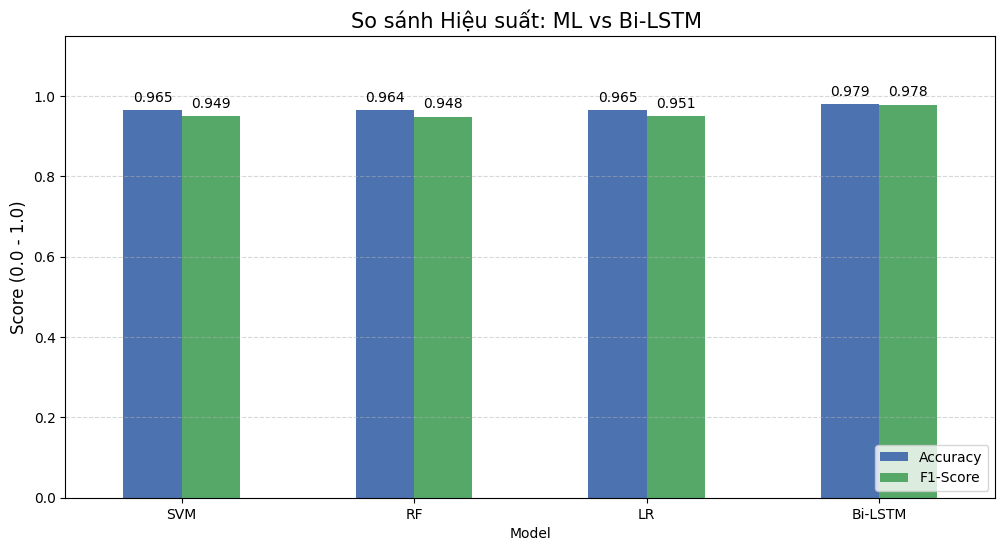


 Đang lưu toàn bộ model vào thư mục 'final_models_v2'...
Đã lưu xong tất cả model! Bạn có thể download folder 'final_models_v2' về.


In [9]:
# ======================================================
# PHẦN 6: ĐÁNH GIÁ TỔNG HỢP, VISUALIZATION & LƯU MODEL
# ======================================================
print("\n Đang tổng hợp kết quả từ 5 Model trên tập Test...")

# 1. Tái tạo DataLoader cho tập Test (Fix lỗi NameError)
# ------------------------------------------------------
# A. Tạo lại Loader cho Bi-LSTM
# Lưu ý: Class LSTMDataset và vocab đã được định nghĩa ở Cell 2
lstm_test_ds = LSTMDataset(test_df['processed_text'].values, [label2id[l] for l in test_df['relation']], vocab)
lstm_test_loader = DataLoader(lstm_test_ds, batch_size=16, shuffle=False)

all_results = []

# Hàm tính metrics chuẩn
def compute_final_metrics(y_true, y_pred, model_name):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    return {
        "Model": model_name,
        "Accuracy": acc,
        "F1-Score": f1,
        "Precision": precision,
        "Recall": recall
    }

# ------------------------------------------------------
# 2. ĐÁNH GIÁ MACHINE LEARNING (SVM, RF, LR)
# ------------------------------------------------------
# X_test_ml, y_test_ml đã được tạo ở bước train ML
for name, model in ml_models.items():
    y_pred = model.predict(X_test_ml)
    metrics = compute_final_metrics(y_test_ml, y_pred, name)
    all_results.append(metrics)
    print(f"    {name} done.")

# ------------------------------------------------------
# 3. ĐÁNH GIÁ BI-LSTM
# ------------------------------------------------------
lstm_model.eval()
lstm_preds = []
lstm_trues = []

with torch.no_grad():
    for x, y in lstm_test_loader: # Dùng lstm_test_loader vừa tạo
        outputs = lstm_model(x.to(device))
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        lstm_preds.extend(preds)
        lstm_trues.extend(y.numpy())

metrics_lstm = compute_final_metrics(lstm_trues, lstm_preds, "Bi-LSTM")
all_results.append(metrics_lstm)
print(f"   Bi-LSTM done.")



# ------------------------------------------------------
# 4. TRỰC QUAN HÓA (VISUALIZATION)
# ------------------------------------------------------
results_df = pd.DataFrame(all_results).set_index("Model")
print("\n================= KẾT QUẢ CUỐI CÙNG =================")
print(results_df)

# Vẽ biểu đồ
plt.figure(figsize=(14, 7))
ax = results_df[['Accuracy', 'F1-Score']].plot(kind='bar', figsize=(12, 6), rot=0, color=['#4c72b0', '#55a868'])
plt.title("So sánh Hiệu suất: ML vs Bi-LSTM ", fontsize=15)
plt.ylabel("Score (0.0 - 1.0)", fontsize=12)
plt.ylim(0, 1.15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='lower right')

# Hiển thị số trên cột
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')
plt.show()

# ------------------------------------------------------
# 6. LƯU TOÀN BỘ MODEL (SAVE ALL)
# ------------------------------------------------------
SAVE_DIR = "final_models_v2"
if not os.path.exists(SAVE_DIR): os.makedirs(SAVE_DIR)

print(f"\n Đang lưu toàn bộ model vào thư mục '{SAVE_DIR}'...")

# 1. Metadata (Quan trọng để load lại sau này)
metadata = {
    "label2id": label2id, 
    "id2label": id2label,
    "lstm_vocab": vocab, # Vocab của LSTM
    "valid_schema": VALID_SCHEMA,
    "results_summary": results_df.to_dict()
}
joblib.dump(metadata, f"{SAVE_DIR}/metadata.pkl")

# 2. ML Models
for name, model in ml_models.items():
    joblib.dump(model, f"{SAVE_DIR}/{name}.joblib")

# 3. Bi-LSTM
torch.save(lstm_model.state_dict(), f"{SAVE_DIR}/bilstm.pth")

print("Đã lưu xong tất cả model! Bạn có thể download folder 'final_models_v2' về.")